In [4]:
#hide
from utils import *

hc("F$0$-Conditioned Vocal Sythesis with WORLD Vocoder")

## Motivation

Being able to change the $F0$ of a vocal track opens up endless possibilities of where this can be applied. Some applications that I can think of is auto-tuner, data augmentation, guided training for language learners or singers etc. We do have a software available to us called *WORLD* that claims to do the same. This is my quest to understand what it offers, what are the and how 

## AIM

To build a system that takes speech signal, an intended F0 contour as inputs and outputs synthesized speech with the new F0 contour.

## Procedure

1. Perform analysis synthesis test using *WORLD* vocoder.
2. 

## WORLD

*WORLD* is free software for high-quality speech analysis, manipulation and synthesis. It can estimate Fundamental frequency (F0), aperiodicity and spectral envelope and also generate the speech like input speech with only estimated parameters.

We can manipulate the F0 during synthesis to get our desired output speech.

## WORLD Vocoder Working Principle

A typical use of *WORLD* vocoder is a 3 to 4 standard steps process.
1. Compute the $F0$ contour of the original audio signal.
2. Compute harmonic envelope $sp$ from the spectrogram of the audio signal.
3. Compute aperiodic envelope $ap$.
4. Feed **modified** $F0$ contour, $sp$ and $ap$ to the *synthesizer module* and get the desired audio signal.

In practice, one can modify $F0$, $sp$ and $ap$ as per required but in most cased we are more interseted in manipulating the $F0$ values.

## Analysis Synthesis Test

In analysis synthesis test, we extract features from a given audio signal and feed it to the synthesizer to synthesize it back with only the features. This tells us how the system works given no alteration in the features.

In [14]:
import pyworld as pw
import modusa as ms
import numpy as np
from scipy import signal

In [70]:
# Load a speech signal
y, sr, title = ms.load("../../../data/fsm-snd/Crocodile 1.mp3", sr=16000, clip=5)
ann = ms.load_ann("../../../data/fsm-snd/Crocodile 1-words.txt", clip=5)

In [8]:
#hide
def compute_spec(y, sr):
    """
    Compute log-compressed power spectrogram.

    Parameters
    ----------
    y: ndarray
        - Audio signal.
    sr: float | int
        - Sampling rate of the audio signal.
    """
    import librosa
    
    N, H = 1024, 160
    S = librosa.stft(y, n_fft=N, win_length=N, hop_length=H)
    S = np.log(1 + 10*(np.abs(S)**2))
    S_f = np.arange(S.shape[0]) * (sr / N)
    S_t = np.arange(S.shape[1]) * (H / sr)

    return S, S_f, S_t

In [5]:
# This is as per what is mentioned in the github repo
_f0, t = pw.dio(y, sr)    # raw pitch extractor
f0 = pw.stonemask(y, _f0, t, sr)  # pitch refinement
sp = pw.cheaptrick(y, f0, t, sr)  # extract smoothed spectrogram
ap = pw.d4c(y, f0, t, sr)         # extract aperiodicity
y_synth = pw.synthesize(f0, sp, ap, sr) # synthesize an utterance using the parameters

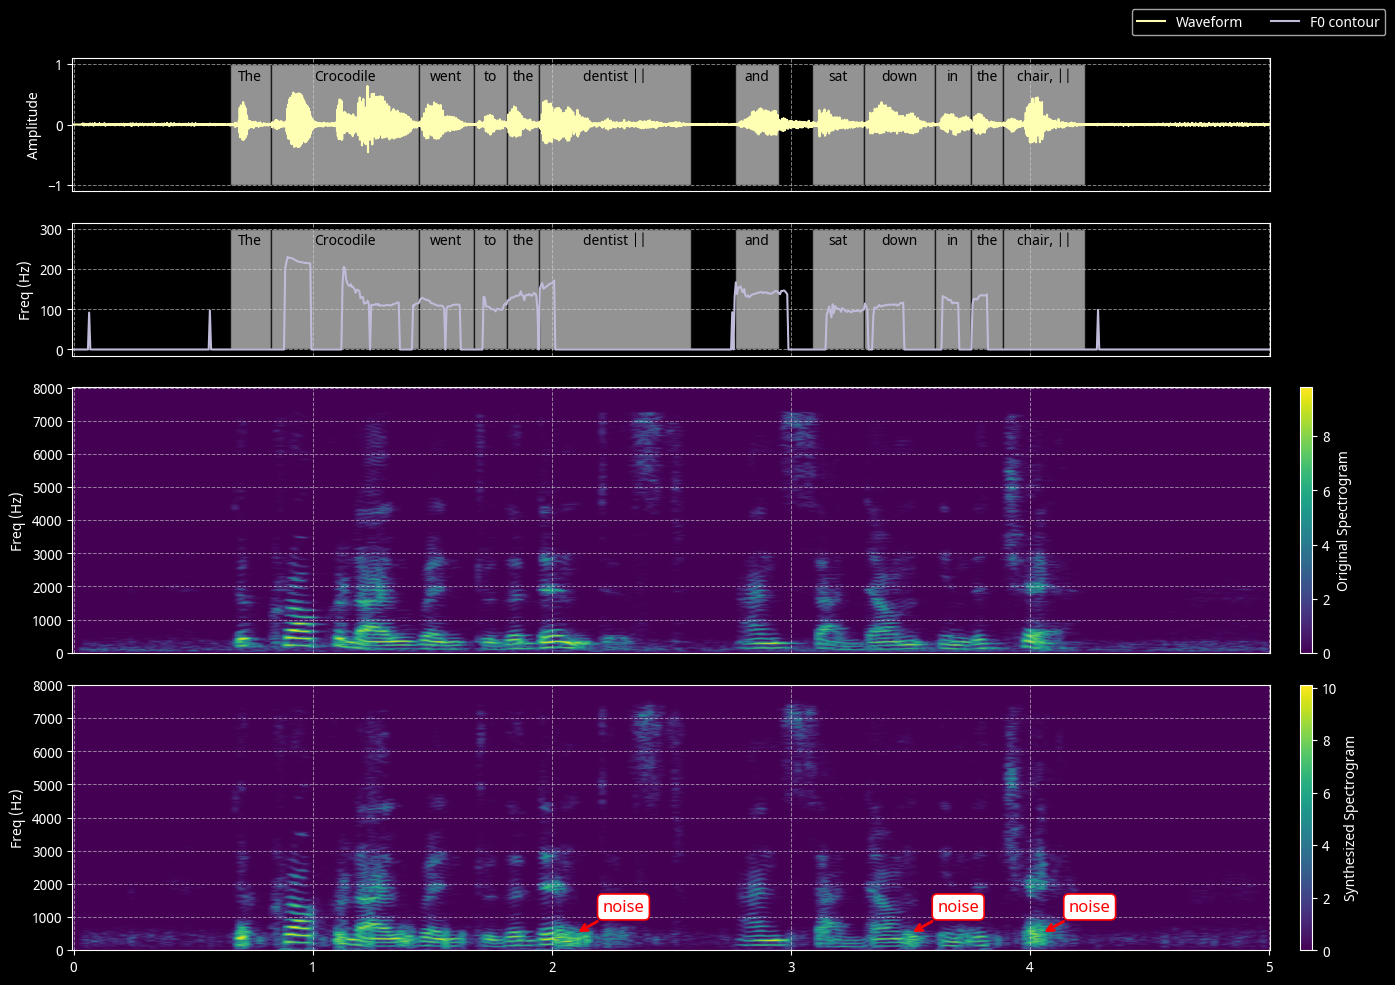

In [6]:
fig = ms.fig("ssmm")

fig.add_signal(y, np.arange(y.size) / sr, label="Waveform", ylabel="Amplitude")
fig.add_annotation(ann, ax=1, ylim=(-1, 1), text_loc="t")

fig.add_signal(f0, t, label="F0 contour", ylabel="Freq (Hz)")
fig.add_annotation(ann, ax=2, ylim=(1, 300), text_loc="t")

fig.add_matrix(*compute_spec(y, sr), ax=3, o="lower", label="Original Spectrogram", ylabel="Freq (Hz)")

fig.add_matrix(*compute_spec(y_synth, sr), ax=4, o="lower", label="Synthesized Spectrogram", ylabel="Freq (Hz)")
fig.add_arrows([(2.1, 500), (3.5, 500), (4.05, 500)], labels="noise", ax=4, text_offset=(0.2, 800))

fig.add_legend(0.9)

We observe noise in the synthesized audio where the $F0$ contour was not detected properly. This suggests that a more accurate pitch contour leads to higher-quality synthesized audio.

*pyworld* also provides a more robust $F0$ detection algorithm. Let’s try it to see if it improves the results.

### Using Havest for Pitch Estimation

In [71]:
_f0, t = pw.harvest(y, sr)    # pitch extractor using harvest method
f0 = pw.stonemask(y, _f0, t, sr)  # pitch refinement
sp = pw.cheaptrick(y, f0, t, sr)  # extract smoothed spectrogram
ap = pw.d4c(y, f0, t, sr)         # extract aperiodicity
y_synth = pw.synthesize(f0, sp, ap, sr) # synthesize an utterance using the parameters

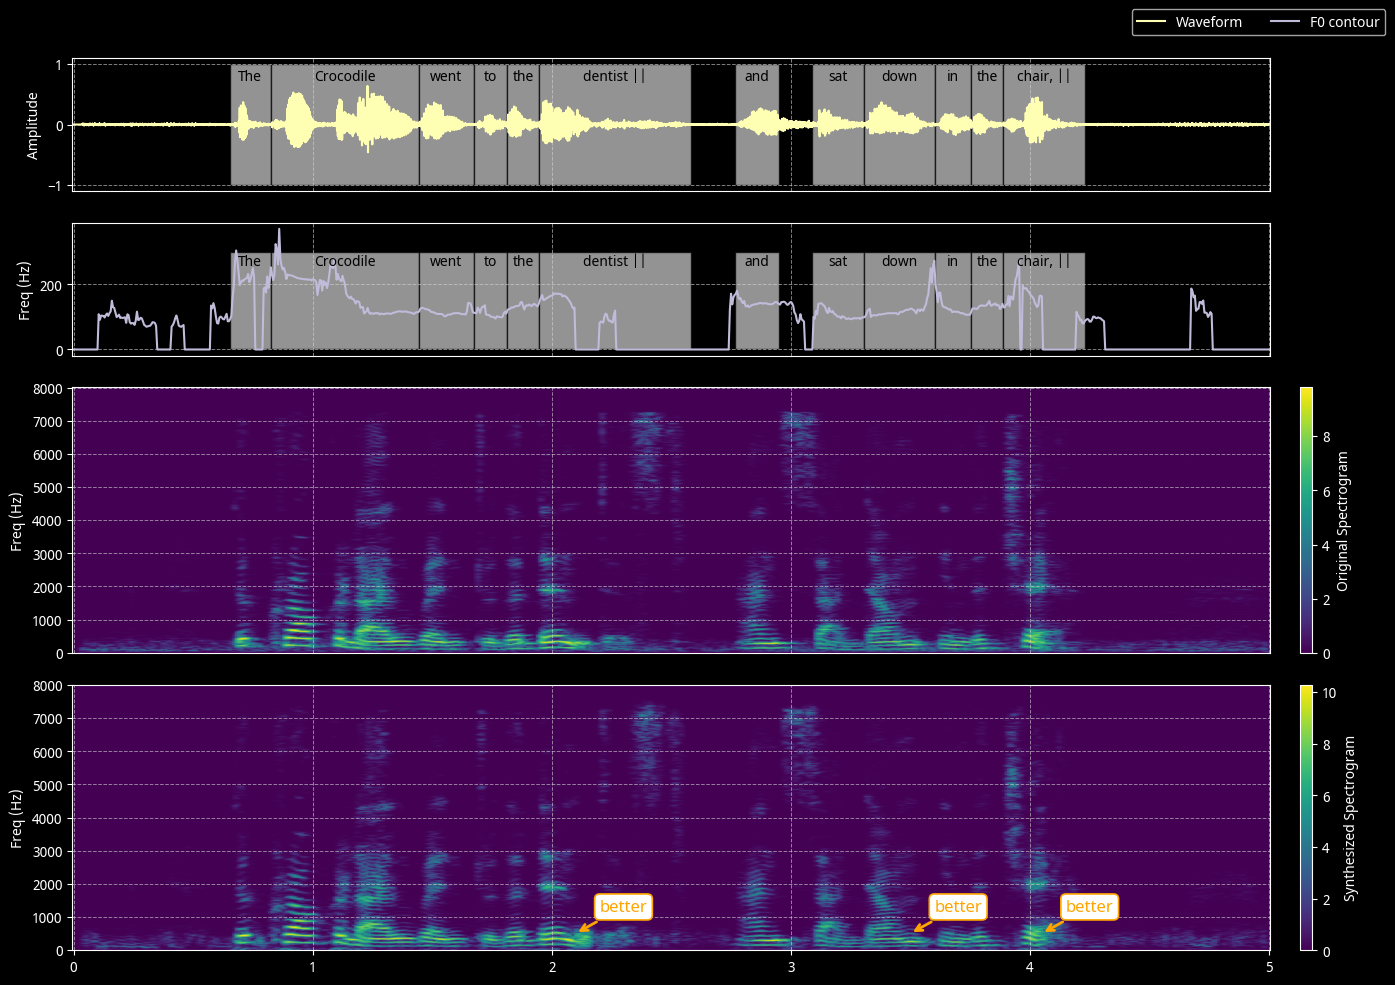

In [75]:
fig = ms.fig("ssmm")

fig.add_signal(y, np.arange(y.size) / sr, label="Waveform", ylabel="Amplitude")
fig.add_annotation(ann, ax=1, ylim=(-1, 1), text_loc="t")

fig.add_signal(f0, t, label="F0 contour", ylabel="Freq (Hz)")
fig.add_annotation(ann, ax=2, ylim=(1, 300), text_loc="t")

fig.add_matrix(*compute_spec(y, sr), ax=3, o="lower", label="Original Spectrogram", ylabel="Freq (Hz)")

fig.add_matrix(*compute_spec(y_synth, sr), ax=4, o="lower", label="Synthesized Spectrogram", ylabel="Freq (Hz)")
fig.add_arrows([(2.1, 500), (3.5, 500), (4.05, 500)], labels="better", ax=4, text_offset=(0.2, 800), c="orange")

fig.add_legend(0.9)

Using the default Harvest settings, the algorithm may produce $F0$ values in noisy regions, but this does not affect synthesis quality. It is recommended to prioritize capturing the $F0$ contour fully, even if it introduces extra values elsewhere.